# Import libraries

In [124]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

In [125]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks"
}

# Load genotype

In [126]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [127]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [128]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load population

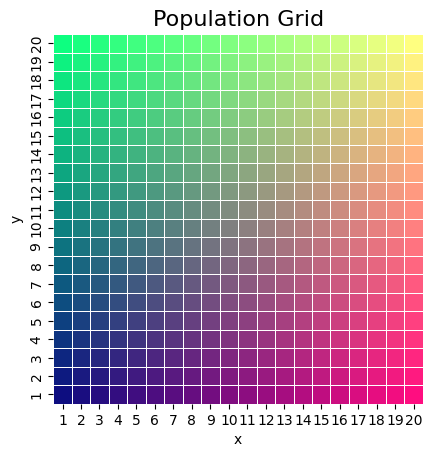

In [129]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Load environmental risk

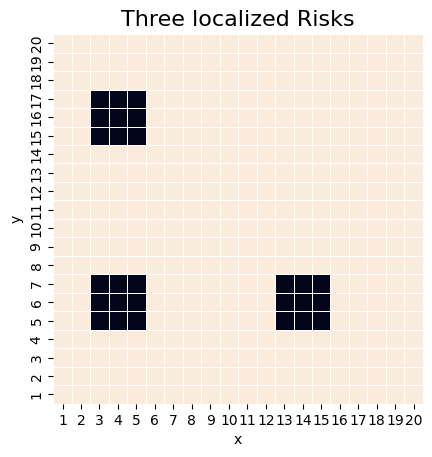

In [130]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
populations[name_risk] = risk[name_risk]
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title(f"{naming_dict[name_risk]}", fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Find true MAF per populations

In [131]:
"""
complete['pop'] = populations['population_number']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []
for pop in list(populations['population_number'].unique()):
    snps = []
    p2s = []
    twopqs = []
    q2s = []
    temp = complete[complete['pop'] == pop]
    temp.drop("pop", axis=1, inplace=True)
    for snp in list(temp.columns):
        try:
            num_maj = temp[[snp]].value_counts()[1]
        except Exception as e:
            num_maj = 0
        try:
            num_het = temp[[snp]].value_counts()[0]
        except Exception as e:
            num_het = 0
        try:
            num_min = temp[[snp]].value_counts()[-1]
        except Exception as e:
            num_min = 0
        total_humans = num_maj + num_het + num_min
        p2 = [num_maj/total_humans]*total_humans
        twopq = [num_het/total_humans]*total_humans
        q2 = [num_min/total_humans]*total_humans
        p2s.append(p2)
        twopqs.append(twopq)
        q2s.append(q2)
        snps.append(snp)
    p2s = pd.DataFrame(p2s).T
    p2s.index = temp.index
    p2s.columns = snps

    twopqs = pd.DataFrame(twopqs).T
    twopqs.index = temp.index
    twopqs.columns = snps

    q2s = pd.DataFrame(q2s).T
    q2s.index = temp.index
    q2s.columns = snps

    p2s_dfs.append(p2s)
    twopqs_dfs.append(twopqs)
    q2s_dfs.append(q2s)

complete.drop("pop", axis=1, inplace=True)

true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

true_p2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")
"""

'\ncomplete[\'pop\'] = populations[\'population_number\']\n\np2s_dfs = []\nq2s_dfs = []\ntwopqs_dfs = []\nfor pop in list(populations[\'population_number\'].unique()):\n    snps = []\n    p2s = []\n    twopqs = []\n    q2s = []\n    temp = complete[complete[\'pop\'] == pop]\n    temp.drop("pop", axis=1, inplace=True)\n    for snp in list(temp.columns):\n        try:\n            num_maj = temp[[snp]].value_counts()[1]\n        except Exception as e:\n            num_maj = 0\n        try:\n            num_het = temp[[snp]].value_counts()[0]\n        except Exception as e:\n            num_het = 0\n        try:\n            num_min = temp[[snp]].value_counts()[-1]\n        except Exception as e:\n            num_min = 0\n        total_humans = num_maj + num_het + num_min\n        p2 = [num_maj/total_humans]*total_humans\n        twopq = [num_het/total_humans]*total_humans\n        q2 = [num_min/total_humans]*total_humans\n        p2s.append(p2)\n        twopqs.append(twopq)\n        q2s.

In [132]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

# Create environment dependend phenotype

In [133]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.1
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
# Calculate the standard deviation of the vector
std_dev = np.std(y)
mean = np.mean(y)
# Standardize the vector
#y = (y - mean) / std_dev
y = (y - mean)
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

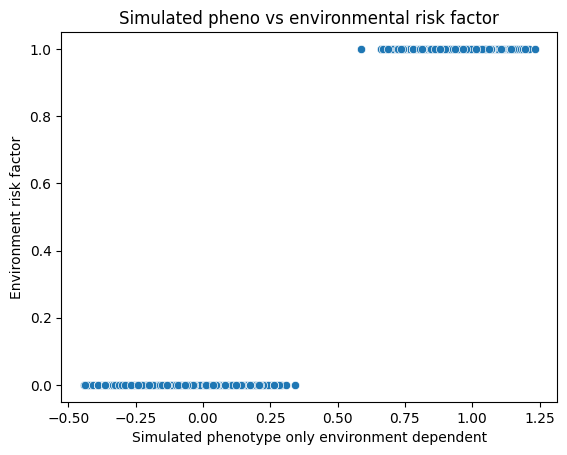

In [134]:
sns.scatterplot(x=list(y), y=list(np.array(risk[name_risk])))
plt.xlabel('Simulated phenotype only environment dependent')
plt.ylabel('Environment risk factor')
plt.title('Simulated pheno vs environmental risk factor')
plt.show()

In [135]:
pheno_corrected = complete.copy()
for snp in list(complete.columns):
    one_hot_encoded_df = pd.get_dummies(complete[snp], prefix=snp).astype(int)
    try:
        one_hot_encoded_df[f"{snp}_-1.0"] = one_hot_encoded_df[f"{snp}_-1.0"]/true_q2s[snp]**2
    except:
        pass
    try:
        one_hot_encoded_df[f"{snp}_0.0"] = one_hot_encoded_df[f"{snp}_0.0"]/true_twopqs[snp]**2
    except:
        pass

    try:
        one_hot_encoded_df[f"{snp}_1.0"] = one_hot_encoded_df[f"{snp}_1.0"]/true_p2s[snp]**2
    except:
        pass

    one_hot_encoded_df = one_hot_encoded_df.fillna(0.0)
    pheno_corrected[snp] = y*one_hot_encoded_df.sum(axis=1)

In [136]:
pheno_corrected

snps,CG3_AF_0.313875,CG6_AF_0.21065,CG13_AF_0.3178,CG14_AF_0.206575,CG17_AF_0.277,CG19_AF_0.3036,CG23_AF_0.2141,CG29_AF_0.303875,CG30_AF_0.304,CG31_AF_0.316825,...,VRG971_AF_0.0261,VRG973_AF_0.04725,VRG976_AF_0.036725,VRG979_AF_0.02685,VRG981_AF_0.02075,VRG989_AF_0.033775,VRG991_AF_0.02855,VRG993_AF_0.02275,VRG998_AF_0.020175,VRG999_AF_0.030175
0,-154.441405,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032,-154.441405,-0.067032,-0.067032,-0.067032,...,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032,-0.067032
1,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.029681,-0.030931,-0.030931,-0.030931,...,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931,-0.030931
2,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.124560,-0.129804,-0.129804,-0.129804,...,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804,-0.129804
3,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.144289,-0.150364,-0.150364,-0.150364,...,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364,-0.150364
4,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.066612,-0.069417,-0.069417,-0.069417,...,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417,-0.069417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,...,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869,-0.099869
19996,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,...,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274,-0.263274
19997,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,...,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122,-0.073122
19998,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,...,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345,-0.216345


# Start comparaisons

In [137]:
# No correction
df_no_corr = manhattan_linear(complete, risk[['pheno']])

Global phenotype
No Covs!


In [138]:
pops = populations[['x','y']]
df_pops = manhattan_linear(complete, y , pops)

Pheno is not None and not a dataframe
Covs


In [139]:
total_corr = []
for snp in list(complete.columns):
    corrected_snps = []
    snps = list(complete[snp])
    p2s = list(true_p2s[snp])
    q2s = list(true_q2s[snp])
    for i in range(len(snps)):
        if snps[i] == -1.0:
            corrected_snps.append(-1.0/q2s[i])
        elif snps[i] == 1.0:
            corrected_snps.append(1.0/p2s[i])
        elif snps[i] == 0.0:
            corrected_snps.append(0.0)
        else:
            pass
    total_corr.append(corrected_snps)
corrected_complete = pd.DataFrame(total_corr).T
corrected_complete.columns = complete.columns

In [140]:
# Correcting genotype
df_corrected_geno = manhattan_linear(corrected_complete, y)

Pheno is not None and not a dataframe
No Covs!


In [141]:
# correcting phenotype
df_corrected_pheno = manhattan_linear(complete, pheno_corrected)

Snp specific phenotype!
No Covs!


In [142]:
# p2 - q2 and 2pq as covariates

In [143]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [144]:
df_p_q_2pq_covs = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [145]:
df_p_q_covs = manhattan_linear(complete, y, true_p2s - true_q2s)

Pheno is not None and not a dataframe
Abyss!


# Create qq plots

In [146]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
df_bests["-logP_corrected_geno_true_mafs"] = np.sort(df_corrected_geno['-logPs'])
df_bests["-logP_corrected_pheno_true_mafs"] = np.sort(df_corrected_pheno['-logPs'])
df_bests["-logP_pq_2pq_as_cov"] = np.sort(df_p_q_2pq_covs['-logPs'])
df_bests["-logP_pq_as_cov"] = np.sort(df_p_q_covs['-logPs'])


In [147]:
# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

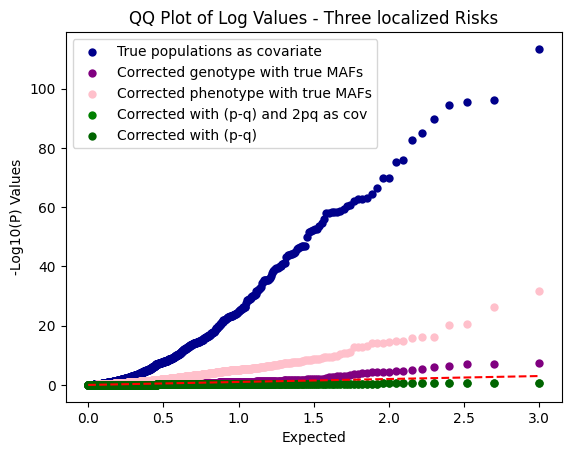

In [149]:
#sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate')

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_corrected_geno_true_mafs', data=df_bests, color='purple', label='Corrected genotype with true MAFs', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_corrected_pheno_true_mafs', data=df_bests, color='pink', label='Corrected phenotype with true MAFs', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_as_cov', data=df_bests, color='darkgreen', label='Corrected with (p-q)', linewidth=0)

# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()